# Modeling

# Inhouds opgaven data understanding

## 1. Libraries
## 2. Data Inladen
## 3. Data retrieve
## 4. Baseline model
## 5. Lineaire regression
## 6. Random forest  regression
## 7. 



# 1. Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 2. Data Inladen

In [5]:
%%capture
%run 3.Data_Preparation.ipynb

In [6]:
prep_list = return_model_data()
table = prep_list[0]
table.head(3)

,#stm_sap_meldnr,stm_sap_meld_ddt,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_status_melding_sap,...,stm_contractgeb_gst,stm_techn_gst,stm_progfh_in_duur,stm_progfh_gw_teller,stm_fh_duur,stm_reactie_duur,stm_meld_gebeld_duur,stm_meld_ter_plekken_duur,stm_gebeld_ter_plekken_duur,stm_equipm_soort_mld_looe_mean
32099,50112759,2012-06-12 20:50:00,104.0,104.0,None,None,0.0,0.0,9.0,MAFS,...,1.0,X,40.0,0.0,43.0,3.0,492.0,495.0,3.0,143.777924
52801,50126248,2014-02-23 07:00:00,38.0,38.0,None,None,0.0,0.0,9.0,MAFS TVTK,...,71.0,X,0.0,0.0,15.0,0.0,0.0,0.0,0.0,138.487138
55827,50127448,2014-04-21 03:37:00,NaN,NaN,None,None,0.0,0.0,9.0,MAFS TVTK,...,30.0,X,0.0,0.0,11.0,0.0,1523.0,0.0,0.0,139.007809


# 3. Baseline model

Hier gebruiken we een dummy classifier om een baseline model aan te maken. We gebruiken hiervoor de optie "most_frequent".

In [7]:
# #DummyClass wordt hier opgeroepen
# BaselineDummyClass = DummyClassifier(strategy='most_frequent',random_state=0)

Hier gebruiken we een dummy regressor voor een baseline model. We gebruiken hier voor de optie mean 

In [18]:
#DummyRegressor
X_train, X_test, Y_train, Y_test = train_test_split(table['stm_progfh_in_duur'], table['stm_fh_duur'])

# We nemen de median die minder gevoelig is voor uit schieters.
BaselineDummyRegressor = DummyRegressor(strategy="mean")
BaselineDummyRegressor.fit(X_train, Y_train)

y_pred = BaselineDummyRegressor.predict(X_test)
accuracy_r2 = BaselineDummyRegressor.score(Y_test, y_pred)

print("First 5 Prediction: ", y_pred[0:5])
print("R2: ",  accuracy_r2)
print("RSME: ", np.sqrt(mean_squared_error(y_pred, Y_test)))

First 5 Prediction:  [134.38347871 134.38347871 134.38347871 134.38347871 134.38347871]
R2:  1.0
RSME:  122.37409600694696


<AxesSubplot:xlabel='stm_fh_duur'>

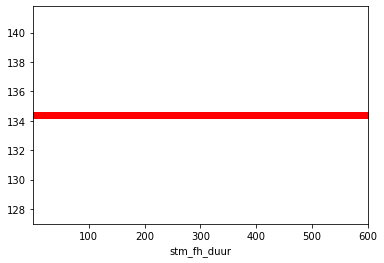

In [19]:
# Prediction tegen eigenlijke uitkomst
sns.regplot(x=Y_test, y=y_pred, ci=None, color="r")

# 4. Lineaire regression

In [20]:
linreg_table = table[['stm_progfh_in_duur','stm_equipm_soort_mld_looe_mean']]
X_train, X_test, Y_train, Y_test = train_test_split(linreg_table, table['stm_fh_duur'])

In [21]:
liniar_reg = LinearRegression()

liniar_reg.fit(X_train,Y_train)

y_pred = liniar_reg.predict(X_test)

accuracy_r2 = r2_score(Y_test, y_pred) 
print("First 5 Prediction: ", y_pred[0:5])
print("R2: ",  accuracy_r2)
print("RSME: ", np.sqrt(mean_squared_error(y_pred, Y_test)))

First 5 Prediction:  [ 86.91035895  97.91753303 274.6802029  244.06229764  85.42024569]
R2:  0.20865385996342423
RSME:  108.37781251691571


Hier is de visualiatie van de regressielijn tegen over een scatter

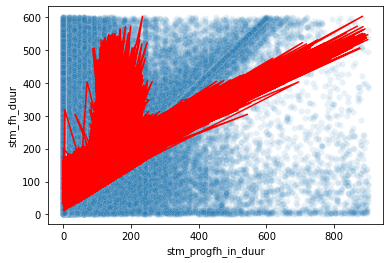

In [22]:
table_copy = table[['stm_progfh_in_duur', 'stm_fh_duur']]
sns.scatterplot(data=table_copy, x="stm_progfh_in_duur", y="stm_fh_duur",alpha=0.1, legend=False, sizes=(20, 2000))
plt.plot(X_test, y_pred, color='r')

<AxesSubplot:xlabel='stm_fh_duur'>

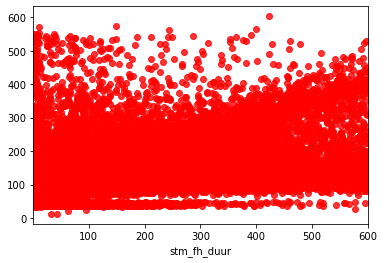

In [23]:
# Prediction tegen eigenlijke uitkomst
sns.regplot(x=Y_test, y=y_pred, ci=None, color="r")

# 5. Random forest  regression

In [28]:
def find_best_tree(table):
    x_coloms = table[['stm_equipm_soort_mld_looe_mean', 'stm_progfh_in_duur', 'stm_gebeld_ter_plekken_duur']].astype('int64').values
    y_coloms = table['stm_fh_duur'].astype('int64').values

    max_depth = 20
    range_depths = range(max_depth)
    min_leaf = [3, 5, 11]
    min_split = [3, 5, 11]
    n_range = [1,2,3,4,5]

    acc_list = []
    meanscore = 999
    meanscore_label = ""
    best_regessors = []
    for n in n_range:
        for dept in range_depths[1:]:
            for leaf in min_leaf:
                for split in min_split:
                    x_train, x_test, y_train, y_test = train_test_split(x_coloms, y_coloms)
                    random_forest = RandomForestRegressor(n_estimators=n, criterion='mse', max_depth=dept, min_samples_leaf = leaf, min_samples_split = split, n_jobs=-2)
                    random_forest.fit(x_train, y_train)
                    y_pred = random_forest.predict(x_test)

                    mean = np.sqrt(mean_squared_error(y_test, y_pred))
                    if mean < meanscore:
                        meanscore = mean  
                        best_regessors = [random_forest]
                        meanscore_label = ("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred), n, dept, leaf, split)
        print('Complete one', n)
    print(meanscore_label)
    
# -uncommend at own risk-
# find_best_tree(table)

Complete one 1
Complete one 2
Complete one 3
Complete one 4
Complete one 5
('RMSE: ', 54.84208889428713, 0.7942541912285178, 5, 10, 11, 3)


In [30]:
x_coloms = table[['stm_equipm_soort_mld_looe_mean', 'stm_progfh_in_duur', 'stm_gebeld_ter_plekken_duur']].astype('int64').values
y_coloms = table['stm_fh_duur'].astype('int64').values

x_train, x_test, y_train, y_test = train_test_split(x_coloms, y_coloms)
random_forest = RandomForestRegressor(n_estimators=5, min_samples_leaf = 11, max_depth=10,  min_samples_split = 3, n_jobs=-2)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)

accuracy_r2 = r2_score(y_test, y_pred)
print("R2: ",  accuracy_r2)
print("RSME: ", np.sqrt(mean_squared_error(y_pred, y_test)))

R2:  0.7902938190773611
RSME:  55.71630007688501


In [ ]:
# importence = random_forest.feature_importances_
# grapfh = pd.Series(importence, x_coloms.columns)
# fig, (ax1) = plt.subplots(1,1, figsize=(20,10))
# grapfh.sort_values().plot.barh(color='blue')
# plt.title('importance randomforest')

# Derde regressie model

In [ ]:
# wat returned het?
def return_models():
    liniar_reg
    return [liniar_reg, random_forest, prep_list[1]]
# preplist is target encoder

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df0a20df-15ef-4481-b361-742b03a94b10' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>